# Control of Two-way Coupled Fluid Systems with Differentiable Solvers


This notebook shows how to train a neural network in an unsupervised way in order for it to act as a controller in an environment with two way coupling.

The source code is provided [here](https://github.com/brenerrr/PhiFlow) in the **two_way_coupling branch**.

First of all, we need to prepare the current environment by downloading and installing all necessary packages to run the code.

In [ ]:
!pip install torch torchvision torchaudio &> /dev/null # Supressing output

# install differentiable simulator from phiflow fork
# treat like a phiflow installation
%cd /content/
!git clone https://github.com/tum-pbs/two-way-coupled-control.git
!mv two-way-coupled-control PhiFlow
%cd PhiFlow
!pip install . ./

/content
Cloning into 'two-way-coupled-control'...
remote: Enumerating objects: 12047, done.
remote: Counting objects: 100% (12047/12047), done.
remote: Compressing objects: 100% (2975/2975), done.
remote: Total 12047 (delta 9318), reused 11583 (delta 8970), pack-reused 0
Receiving objects: 100% (12047/12047), 22.05 MiB | 13.82 MiB/s, done.
Resolving deltas: 100% (9318/9318), done.
/content/PhiFlow
Processing /content/PhiFlow
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233

In [ ]:
# Import libraries
from math import ceil
import argparse
from time import time
import json
from collections import OrderedDict
from neural_control.neural_networks.NeuralController import NeuralController
from neural_control.misc.TwoWayCouplingSimulation import *
from neural_control.InputsManager import *

# Inputs

All inputs that control training and simulation are set below. The default values below are the ones used to train a controller for a 2 degrees of freedom environment (disc).

In [ ]:
n_timesteps = 1000       # Number of timesteps per simulation
n_iterations = 1000      # Number of weights updates
n_before_backprop = 16   # Number of timesteps before updating weights
past_window = 2          # Number of past states that are sent to the network
hyperparams = {          # Loss hyperparameters
    "spatial": 15,       #
    "velocity": 5,
    "force": 0.1,
    "delta_force": 5.0,
    "angle": 0,
    "torque": 0,
    "ang_velocity": 0,
    "delta_torque": 0,
    "proximity": 0.1
}
learning_rate = 0.01
lr_half_life = 201       # Amount of iterations necessary for learning rate dropping by half
max_acc = 1              # Maximum acceleration used to calculate maximum control force
seed = 100               # Weights initilization seed
export_path = "/content/PhiFlow/storage/diff_2dof/" # Path to where output files will be saved
simulation_path = "/content/PhiFlow/storage/ics/training_2dof/" # Path to simulation used as initial condition



## Less critical inputs


In [ ]:
translation_only = True # 2 DoF
nn_vars = [
    "obs_vx",
    "obs_vy",
    "error_x",
    "error_y",
    "control_force_x",
    "control_force_y"
]
device_str = "CPU"
max_ang_acc = 0
architecture = "fc_only"
export_stride = 50
model_export_stride = 100
optimizer_str = "AdamW"
destinations_margins = np.array([20,20])
destinations_zone_growrate = 0.33
# Simulation parameters
re = 1000
obs_density = 0.15
reference_velocity = 1
reference_length = 5
inflow_on = False
dt = 0.1
obs_type = "disc"
obs_width = 5
obs_height = 5
time_step_scheme = "RK2"
domain_size = np.array([80,80])
obs_xy = [40,40]
sponge_intensity = 0.01
sponge_size = [5,5,5,5]
obs_mass = 11.780972450961725
obs_inertia = 49.087385212340514
export_vars = [
    "pressure","vx","vy","obs_mask","obs_xy","obs_vx","obs_vy",
    "control_force_x","control_force_y","fluid_force_x","fluid_force_y",
    "reference_x","reference_y","error_x", "error_y","fluid_torque","vorticity","cfl"]


# Pre processing

With all inputs set, the simulation and training classes can be initialized as well as generating the objectives that will be used during training.

## Setup simulation

In [ ]:
TORCH_BACKEND.set_default_device("CPU")
device = torch.device("cpu")
sim = TwoWayCouplingSimulation(device, translation_only)
sim.set_initial_conditions(obs_type, obs_width, obs_height, path=simulation_path)
# Reference variables used to map physical values to network inputs/outputs
ref_vars = dict(
    velocity=reference_velocity,
    length=reference_length,
    force=obs_mass * max_acc,
    angle=PI,
    torque=obs_inertia * max_ang_acc,
    time=obs_width / reference_velocity,
    ang_velocity=reference_velocity / obs_width
)
destinations_zone_size = domain_size - destinations_margins * 2


Loading default value for obs_vx
Loading default value for obs_vy
Loading default value for obs_ang
Loading default value for obs_ang_vel
Did not found data of second obstacle


## Setup network/training

In [ ]:
n_features = defaultdict(lambda: 1)
n_past_features = np.sum([n_features[var] for var in nn_vars])
n_present_features = np.sum([n_features[var] for var in nn_vars if "control" not in var])
training_dt = dt
model = NeuralController(
    f"{architecture}{past_window}",
    2 if translation_only else 3,
    n_present_features,
    n_past_features,
    past_window)
torch.manual_seed(seed + 1)
model.to(device)
print("\n\n Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n Total amount of trainable parameters: {total_params}")
optimizer_func = getattr(torch.optim, optimizer_str)
optimizer = optimizer_func(model.parameters(), lr=learning_rate)
decay = np.exp(np.log(0.5) / lr_half_life)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay)



 Model's state_dict:
layers.0.weight 	 torch.Size([38, 16])
layers.0.bias 	 torch.Size([38])
layers.1.weight 	 torch.Size([38, 38])
layers.1.bias 	 torch.Size([38])
layers.2.weight 	 torch.Size([2, 38])
layers.2.bias 	 torch.Size([2])

 Total amount of trainable parameters: 2206


## Setup objectives

In [ ]:
first_case = 0
os.makedirs( export_path , exist_ok=True)
torch.save(model.state_dict(),f"{export_path}initial_model_{first_case}.pt")
# Number of simulations necessary to achieve desired number of iterations
n_simulations = n_iterations / (n_timesteps / n_before_backprop)
# Add double the necessary  amount just in case some exhibit early termination
n_simulations = ceil(n_simulations) * 2
# Create objectives
torch.manual_seed(seed + 2)
xy = torch.rand(2, n_simulations)
ang = torch.rand(n_simulations)
for case in range(n_simulations):
    growrate = np.min((destinations_zone_growrate * (case + 1), 1.))
    margins = (domain_size - destinations_zone_size * growrate) / 2
    xy[:, case] = xy[:, case] * destinations_zone_size * growrate + margins
    ang[case] = ((ang[case] * 2 * PI - PI) * growrate)
# Save objectives
objective_xy = xy.numpy().T.tolist()
objective_ang = ang.numpy().tolist()
objective_xy = xy.to(device)
objective_ang = ang.to(device)

## Export parameters

In [ ]:
# Save parameters to json file
inp = {
    "export_vars" : export_vars,
    "translation_only" : translation_only,
    "architecture" : architecture,
    "past_window" : 2,
    "export_stride" : export_stride,
    "max_acc" : max_acc,
    "max_ang_acc": max_ang_acc,
    "device" : "CPU",
    "bypass_tanh" : False,
    "nn_vars" : nn_vars,
    "training_dt" : dt,
    "n_present_features": int(n_present_features),
    "n_past_features" : int(n_past_features),
    "ref_vars": ref_vars,
    "unsupervised" : {
        "simulation_path": simulation_path,
        "destinations_zone_growrate": destinations_zone_growrate,
        "n_timesteps": n_timesteps,
        "lr_half_life": lr_half_life,
        "n_iterations": n_iterations,
        "learning_rate": learning_rate,
        "n_before_backprop": n_before_backprop,
        "model_export_stride": model_export_stride,
        "optimizer": optimizer_str,
        "destinations_margins": destinations_margins.tolist(),
        "hyperparams": hyperparams,
    }
}
with open(f'/content/PhiFlow/storage/diff_2dof/inputs.json', 'w') as f:
    json.dump(inp, f, indent=4)

# Training

The pseudcode below summerizes the core of the training loop.

```
while i_bp < n_iterations
    Reset simulation
    Initialize variables with zero

    for i in range(n_timesteps)
        Apply fluid and control forces
        Calculate fluid and body states at the next timestep
        Use current and past states to compute control effort with neural network
        
        if i - last_backprop == n_before_backprop
            Calculate loss
            Update network weights
            last_backprop = i
        
        Store current state as past state
```


The loss function used to update the network weights is expressed as

$$L = O + V + E$$

$$O = \frac{\beta_{xy}}{l}\sum_{n=0}^{l-1}\|e_{xy}^n\|^2 + \frac{\beta_{\alpha}}{l}\sum_{n=0}^{l-1} \|e_{\alpha}^n\|^2$$

$$V = \frac{\beta_{\dot{x}}}{l}\sum_{n=0}^{l-1}\frac{\|\dot{x}^n\|^2}{\beta_{prox}\|e_{xy}^n\|^2 + 1} + \frac{\beta_{\dot{\alpha}}}{l}\sum_{n=0}^{l-1}\frac{\|\dot{\alpha}^n\|^2}{\beta_{prox}\|e_{\alpha}^n\|^2 + 1}$$

$$ E = \frac{\beta_F}{l}\sum_{n=0}^{l-1} \|F_c^n\|^2
    + \frac{\beta_T}{l}\sum_{n=0}^{l-1} \|T_c^n\|^2 +
      \frac{\beta_{\Delta F}}{l}\sum_{n=0}^{l-1} \|F_c^n-F_c^{n-1}\|^2
    + \frac{\beta_{\Delta T}}{l}\sum_{n=0}^{l-1} \|T_c^n-T_c^{n-1}\|^2 $$

where $\dot{x}$
and $\dot{\alpha}$
represent velocities,
$e$ errors,
and $F_c$
and $T_c$
control efforts. $\beta$ are hyperparameters that weigh the contribution of each term.

Intermediate models are saved during training before all iterations are performed as *trained_model_####.pt*, where #### is a model index.


<br>
<p align="center">
<img src="https://github.com/brenerrr/PhiFlow/blob/two_way_coupling/schematic.png?raw=true" height=250/>
<img src="https://raw.githubusercontent.com/brenerrr/PhiFlow/two_way_coupling/training_box.gif" width="250" height="250"/>
<figcaption align = "center"><b>A schematic of the differentiable solver training: Blue arrows represent the forward pass while red ones illustrate the flow of gradients. Importantly, the loss signal is backpropagated through l simulation steps to provide policy P with long-term feedback about the flow environment.</b></figcaption>
</p>
<br>







## Functions

Below there are the main auxiliary functions needed for training.



### Extract inputs
Extract the variables listed as strings in *vars* from the simulation environment. Those are latter used as inputs for the neural network and loss calculation.

In [ ]:
def extract_inputs(vars, sim, x_objective, angle_objective, ref_vars: dict = None, translation_only = False):
    """
    Params:
        vars: list of variables that will be used for extracting inputs
        sim: simulation object
        x_objective : final destination in xy space
        angle_objective: angle that the box should go to
        ref_vars: reference variables for non dimensionalizing/normalizing inputs
        translation_only: if true then inputs that are related with rotation will not be gathered

    Returns:
        model_inputs: tensor containing inputs for model
        loss_inputs: tensor containing inputs for loss

    """

    if not ref_vars: ref_vars = defaultdict(lambda: 1)
    getter = dict(
        obs_vx=lambda: sim.obstacle.velocity.native()[0].view(1),
        obs_vy=lambda: sim.obstacle.velocity.native()[1].view(1),
        error_x=lambda: (x_objective[0] - sim.obstacle.geometry.center[0]).native().view(1),
        error_y=lambda: (x_objective[1] - sim.obstacle.geometry.center[1]).native().view(1),
        fluid_force_x=lambda: sim.fluid_force.native()[0].view(1),
        fluid_force_y=lambda: sim.fluid_force.native()[1].view(1),
        error_ang=lambda: (angle_objective - (sim.obstacle.geometry.angle - PI / 2)).native().view(1),
        fluid_torque=lambda: math.sum(sim.fluid_torque).native().view(1),
        obs_ang_vel=lambda: sim.obstacle.angular_velocity.native().view(1),
        control_force_x=lambda: None,
        control_force_y=lambda: None,
        control_torque=lambda: None,
    )

    ref_vars_hash = dict(
        obs_vx="velocity",
        obs_vy="velocity",
        error_x="length",
        error_y="length",
        fluid_force_x="force",
        fluid_force_y="force",
        control_force_x="force",
        control_force_y="force",
        error_ang="angle",
        fluid_torque="torque",
        control_torque="torque",
        obs_ang_vel="ang_velocity",
    )

    inputs = OrderedDict()
    for var in vars:
        value = getter[var]()
        if value is not None: inputs[var] = value / ref_vars[ref_vars_hash[var]]

    for key in inputs:
        if 'x' in key: xy = [inputs[key], inputs[key.replace('x', 'y')]]
        else: continue
        inputs[key], inputs[key.replace('x', 'y')] = xy

    # Transfer values of inputs to tensor
    model_inputs = torch.cat(list(inputs.values())).view(1, 1, -1)

    # Loss inputs
    loss_inputs = dict(
        error_x=inputs["error_x"],
        error_y=inputs["error_y"],
        obs_vx=inputs["obs_vx"],
        obs_vy=inputs["obs_vy"]
    )

    return model_inputs, loss_inputs

### Calculate loss
Calculate the loss as described in the previous section.

In [ ]:

def calculate_loss(loss_inputs, hyperparams, translation_only = False):
    """
    Params:
        loss_inputs: inputs needed for calculating loss
        hyperparams: hyperparameters of loss terms. Should have the following keys
            - spatial
            - velocity
            - angle
            - ang_velocity
            - delta_force
            - delta_torque
            - proximity
        translation_only: if True then additional terms won't be calculated

    Returns:
        loss: loss value
        spatial_term: loss term that accounts for space position of obstacle
        velocity_term: loss term that accounts for obstacle velocity
        ang_term: loss term that accounts for obstacle angle
        ang_vel_term: loss term that accounts for obstacle angular velocity

    """
    error_xy = torch.cat((loss_inputs['error_x'], loss_inputs['error_y']), dim=-1)
    obs_velocity = torch.cat((loss_inputs['obs_vx'], loss_inputs['obs_vy']), dim=-1)
    delta_force = torch.cat((loss_inputs['d_control_force_x'], loss_inputs['d_control_force_y']), dim=-1)
    force = torch.cat((loss_inputs['control_force_x'], loss_inputs['control_force_y']), dim=-1)
    spatial_term = hyperparams['spatial'] * torch.sum(error_xy**2)
    dforce_term = hyperparams['delta_force'] * torch.sum(delta_force**2)
    force_term = hyperparams['force'] * torch.sum(force**2)

    # Other terms are pronounced only when spatial or angular error are low
    velocity_term = hyperparams['velocity'] * torch.sum(obs_velocity**2 / (torch.sum(error_xy**2, 2, keepdim=True)**2 * hyperparams['proximity'] + 1))
    ang_term = ang_vel_term = dtorque_term = torque_term = torch.tensor(0) # 2 DOF

    loss = (
        spatial_term +
        velocity_term +
        ang_term +
        ang_vel_term +
        dtorque_term +
        dforce_term +
        force_term +
        torque_term
    ) / error_xy.shape[0]  # Take mean over rollouts

    loss_terms = dict(
        spatial=spatial_term,
        velocity=velocity_term,
        ang=ang_term,
        ang_vel=ang_vel_term,
    )

    return loss, loss_terms

### Update Inputs
Updates the stack of network inputs tensor by adding the inputs from the present to it and getting rid of the oldest ones in the stack.

In [ ]:
def update_inputs(past_inputs, present_inputs, *control_effort):
    """
    Params:
        past_inputs: network inputs from previous timesteps
        present_inputs: network inputs of current timestep
        *control_effort: outputs of network at current timestep

    Returns:
        new_past_inputs: updated past inputs

    """
    new_past_inputs = torch.cat((
        past_inputs[1:, :, :],
        torch.cat((present_inputs.view(-1), torch.cat(control_effort).view(-1))).view(1, 1, -1)),
        dim=0)

    return new_past_inputs

## Training Loop

In [ ]:
last_time = time()
i_bp = 0
case = 0
while i_bp < n_iterations:
    # Setup case with default initial values
    sim.setup_world(re, domain_size, dt, obs_mass, obs_inertia,
                    reference_velocity, sponge_intensity, sponge_size, inflow_on)

    # Variables initialization
    nn_inputs_past = torch.zeros((past_window, 1, n_past_features)).to(device)
    loss_inputs = defaultdict(lambda: torch.zeros((n_before_backprop, 1, 1)).to(device))
    control_effort = torch.zeros(2).to(device)
    last_control_force = torch.zeros(2).to(device)
    control_force_global = torch.zeros(2).to(device)
    control_force = torch.zeros(2).to(device)
    control_torque = torch.zeros(1).to(device)
    last_control_torque = torch.zeros(1).to(device)
    loss = torch.zeros(1).to(device)
    loss_terms = defaultdict(lambda: 0)

    # Run simulation
    for i in range(0, n_timesteps + 1):
        # Check CFL in the first iterations due to possible numerical instabilities
        if case < 10:
            if math.max(math.abs(sim.velocity.values)) * sim.dt > 1.5:
                print("CFL too big. Resetting simulation")
                break

        sim.apply_forces(control_force_global * ref_vars['force'], control_torque * ref_vars['torque'])
        sim.advect()

        # In case body escapes domain
        if math.any(sim.obstacle.geometry.center > domain_size) or math.any(sim.obstacle.geometry.center < (0, 0)):
            print("Obstacle is out of bounds. Resetting simulation")
            break

        sim.make_incompressible()
        sim.calculate_fluid_forces()

        # Control
        nn_inputs_present, loss_inputs_present = extract_inputs(nn_vars, sim, objective_xy[:, case], objective_ang[case], ref_vars, translation_only)
        if i < past_window: last_backprop = i  # Wait to backprop until past inputs are cached
        else:
            control_effort = model(nn_inputs_present.view(1, -1), nn_inputs_past.view(1, -1))
            control_force = control_effort[0, :2]
            loss_inputs_present['d_control_force_x'], loss_inputs_present['d_control_force_y'] = (control_force - last_control_force)
            loss_inputs_present['control_force_x'], loss_inputs_present['control_force_y'] = control_force
            last_control_force = control_force
            control_force_global = control_force

            # Add inputs from present to loss_inputs dict
            for key in loss_inputs_present:
                loss_inputs[key] = torch.cat((loss_inputs[key][1:, ...], loss_inputs_present[key].view(1, 1, 1)))

            # Update weights
            if (i - last_backprop == n_before_backprop):
                loss, loss_terms = calculate_loss(loss_inputs, hyperparams, translation_only)
                loss.backward()
                optimizer.step()
                i_bp += 1

                # Export model
                if i_bp % model_export_stride == 0:
                    model_id = int(i_bp / model_export_stride)
                    print(f"Saving model {model_id}")
                    print(f"Time left: {time_left_hours:d}h {time_left_minutes:d} min")
                    torch.save(model.state_dict(), os.path.abspath(f"{export_path}trained_model_{model_id:04d}.pt"))

                if i_bp == n_iterations: break
                lr_scheduler.step()  # Decay learning rate after backprop
                optimizer.zero_grad()

                # Reset graph
                control_force = None
                loss_inputs = {key: value.detach() for key, value in loss_inputs.items()}
                control_effort = control_effort.detach()
                last_control_force = last_control_force.detach()
                # control_torque = control_torque.detach()
                # last_control_torque = last_control_torque.detach()
                nn_inputs_present = nn_inputs_present.detach()
                nn_inputs_past = nn_inputs_past.detach()
                control_force_global = control_force_global.detach()
                sim.detach_variables()
                last_backprop = i

        nn_inputs_past = update_inputs(nn_inputs_past, nn_inputs_present, control_effort)

        # ----------------------------------------------
        # -------------------- Export ------------------
        # ----------------------------------------------
        if (i % export_stride != 0): continue
        sim.loss = loss.detach()
        for key, value in loss_terms.items():
            setattr(sim, f"loss_{key}", value.detach())
        sim.reference_x = objective_xy[0, case].detach()
        sim.reference_y = objective_xy[1, case].detach()
        sim.control_force_x, sim.control_force_y = control_force_global.detach() * ref_vars['force']
        sim.error_x = loss_inputs_present['error_x'].detach() * ref_vars['length']
        sim.error_y = loss_inputs_present['error_y'].detach() * ref_vars['length']
        sim.export_data(export_path, case, int(i / export_stride), export_vars, (case == 0 and i == 0))
        # Calculate how much time is left
        current_time = time()
        steps_left = (((n_simulations / 2 - 1) - (case + 1)) * n_timesteps + n_timesteps - (i + 1)) / export_stride
        time_left = steps_left * (current_time - last_time) / 3600
        last_time = current_time
        time_left_hours = int(time_left)
        time_left_minutes = int((time_left - time_left_hours) * 60)
        # print(f"Time left: {time_left_hours:d}h {time_left_minutes:d} min")
        i += 1
    case += 1


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/PhiFlow/phi/math/_tensors.py:172: UserWarning: Slicing with sequence should only be used for channel dimensions.
  warnings.warn("Slicing with sequence should only be used for channel dimensions.")
/content/PhiFlow/phi/torch/_torch_backend.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  tensor = torch.tensor(x, device=self.get_default_device().ref)


Pressure did not converge. Trying again with different initial guess


/content/PhiFlow/phi/math/backend/_numpy_backend.py:232: RuntimeWarning: overflow encountered in exp
  return np.exp(x)


Pressure did not converge. Trying again with different initial guess
Pressure did not converge. Trying again with different initial guess
Saving model 1
Time left: 0h 53 min
Saving model 2
Time left: 0h 50 min
Saving model 3
Time left: 0h 36 min
Saving model 4
Time left: 0h 32 min
Saving model 5
Time left: 0h 41 min
Saving model 6
Time left: 0h 19 min
Pressure did not converge. Trying again with different initial guess
Saving model 7
Time left: 0h 15 min
Saving model 8
Time left: 0h 7 min
Saving model 9
Time left: 0h 1 min
Saving model 10
Time left: 0h -5 min


# Testing

Although the network is trained in a simple environment with a quiescent flow as initial condition, it is able to handle more complex test scenarios. Here we will run a test with a source of lighter fluid on the bottom of the domain that rises due to buoyancy which creates challenging perturbations.

## Generate tests

In [ ]:
%%capture
!python neural_control/testing/generate_tests.py

## Run test simulations

In [ ]:
dt = 0.05
model_id = 10
run_path = "/content/PhiFlow/storage/diff_2dof/"
flag_onesim = True
tests_id = ['test2']
test_label = "test2"
device = torch.device("cpu")
export_path = f"{run_path}/tests/{test_label}_{model_id}/"
sponge_intensity = 0.05

# Load tests json
tests = InputsManager("/content/PhiFlow/neural_control/tests.json", tests_id)
test = tests.__dict__['test2']

# Create list of scalar variables that will be exported every step
export_vars_scalar = list(export_vars)
for entry in list(export_vars_scalar):
    if entry in ["pressure", "vx", "vy", "obs_mask", "vorticity"]:
        export_vars_scalar.remove(entry)
    if "loss" in entry:
        export_vars_scalar.remove(entry)
        inp.export_vars.remove(entry)

# Save tests used in this script
tests.export(export_path + "tests.json", only=[test_label, "dataset_path", "tvt_ratio"])

# Save a copy of the model that will be used for tests
torch.save(model.state_dict(), os.path.abspath(f"{export_path}model.pt"))

# Set simulation parameters
sim = TwoWayCouplingSimulation(device, True)
sim.set_initial_conditions(obs_type, obs_width, obs_height, test["initial_conditions_path"], obs_xy=obs_xy)

sampling_stride = 2  # Test 2 uses half of the training dt

last_time = 0
with torch.no_grad():
    is_first_export = True  # Used for deleting previous files on folder
    for test_i, test_attrs in enumerate(value for key, value in test.items() if 'case' in key):
        export_stride = test_attrs["export_stride"]

        # Initialize tensors
        nn_inputs_past = torch.zeros((past_window, 1, n_past_features)).to(device)
        control_force = torch.zeros(2).to(device)
        control_force_global = torch.zeros(2).to(device)
        control_torque = torch.zeros(1).to(device)

        # Initialize simulation
        smoke_attrs = test_attrs['smoke']
        sim.setup_world(re, domain_size, dt, obs_mass, obs_inertia, reference_velocity,
            sponge_intensity, sponge_size, inflow_on,
            smoke_attrs['buoyancy'] if smoke_attrs['on'] else (0, 0))
        if smoke_attrs['on']:
            for xy in smoke_attrs['xy']:
                sim.add_smoke(xy, smoke_attrs['width'], smoke_attrs['height'], smoke_attrs['inflow'])
            if "smoke" not in export_vars: export_vars.append("smoke")

        for i in range(test_attrs['n_steps']):
            for x_objective_, _, objective_i in zip(test_attrs['positions'], test_attrs['angles'], test_attrs['i']):
                # Check if objective changed
                if i > objective_i:
                    x_objective = torch.tensor(x_objective_).to(device)
            sim.apply_forces(control_force_global * ref_vars['force'], 0)
            sim.advect()
            sim.make_incompressible()
            sim.calculate_fluid_forces()

            # Control
            if i % sampling_stride == 0:
                nn_inputs_present, loss_inputs = extract_inputs(nn_vars, sim,
                    x_objective, 0, ref_vars, translation_only)
                control_effort = model(nn_inputs_present.view(1, -1),
                    nn_inputs_past.view(1, -1) if past_window else None                    )

                # Cache
                if i < past_window * sampling_stride: control_effort = torch.zeros_like(control_effort)
                control_force = control_effort[0, :2]
                control_force_global = control_force
                nn_inputs_past = update_inputs(nn_inputs_past, nn_inputs_present, control_effort)

            # Stop simulation if obstacle escapes domain
            if math.any(sim.obstacle.geometry.center > domain_size) or math.any(sim.obstacle.geometry.center < (0, 0)):
                break

            # Time estimate variables
            now = time()
            delta = now - last_time
            last_time = now

            # ----------------------------------------------
            # ------------------- Export -------------------
            # ----------------------------------------------
            sim.reference_x = x_objective[0].detach()
            sim.reference_y = x_objective[1].detach()
            sim.control_force_x, sim.control_force_y = control_force_global.detach() * ref_vars['force']
            sim.error_x = loss_inputs['error_x'].detach() * ref_vars['length']
            sim.error_y = loss_inputs['error_y'].detach() * ref_vars['length']
            # If not on stride export just scalar values
            if (i % export_stride != 0):  # or (i < inp.past_window + 1):
                export_vars_ = export_vars_scalar
            else:
                export_vars_ = export_vars
                # Print remaining time
                tests_remaining = len([key for key in test.keys() if 'case' in key]) - test_i - 1
                i_remaining = tests_remaining * test_attrs['n_steps'] * (1 - flag_onesim) + (test_attrs['n_steps'] - i - 1)
                remaining = i_remaining * delta
                remaining_h = np.floor(remaining / 60. / 60.)
                remaining_m = np.floor(remaining / 60. - remaining_h * 60.)
                # print(f"Time left: {remaining_h:.0f}h and {remaining_m:.0f} min - i: {i}")
            sim.export_data(export_path, test_i, i, export_vars_ , is_first_export)
            is_first_export = False
        if flag_onesim: break



Loading default value for obs_vx
Loading default value for obs_vy
Loading default value for obs_ang
Loading default value for obs_ang_vel
Did not found data of second obstacle
Pressure did not converge. Trying again with different initial guess
Pressure did not converge. Trying again with different initial guess
Pressure did not converge. Trying again with different initial guess
Pressure did not converge. Trying again with different initial guess
Pressure did not converge. Trying again with different initial guess


### Run test simulation on pre trained model with supervised learning

In [ ]:
%%capture
# Test model pretrained with supervised learning
!python neural_control/testing/test_networks.py /content/PhiFlow/storage/trained_models/supervised_2dof 10 2 -onesimulation

#  Metrics

After the test is done, the metrics of the network performance can be calculated and saved to a json file on */content/PhiFlow/storage/diff_2dof/tests/test2_10/metrics.json*. The code below calculates the metrics and plots the error of different cases used in test 2.

In [ ]:
%%capture
!python neural_control/misc/group_frames.py /content/PhiFlow/storage/diff_2dof
!python neural_control/misc/calculate_metrics.py /content/PhiFlow/storage/diff_2dof

!python neural_control/misc/group_frames.py /content/PhiFlow/storage/trained_models/supervised_2dof
!python neural_control/misc/calculate_metrics.py /content/PhiFlow/storage/trained_models/supervised_2dof

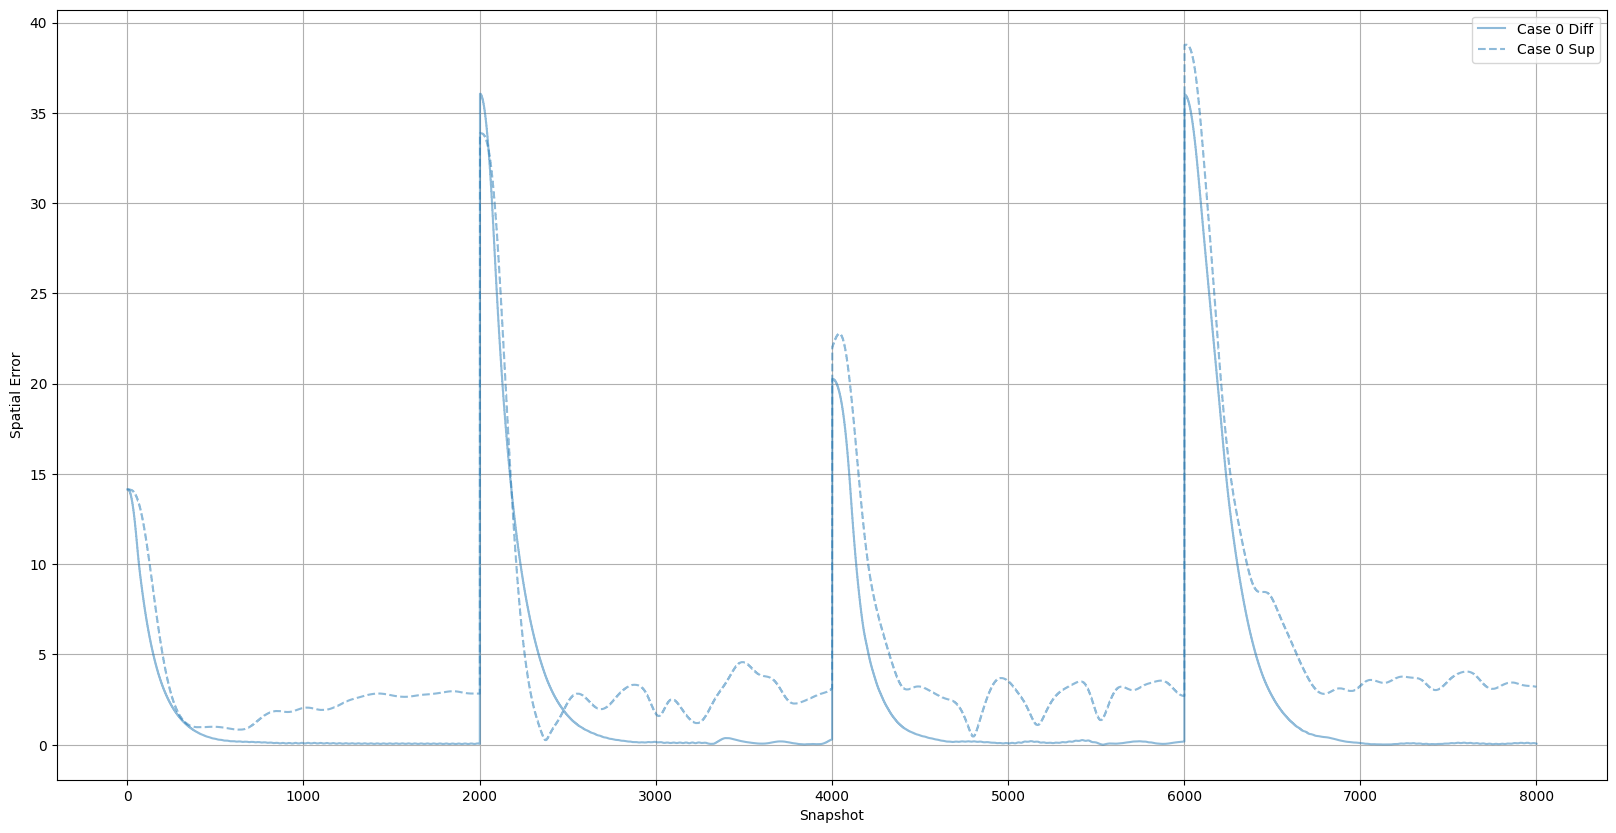

In [ ]:
# Plot spatial error of cases ran in test
import json
import numpy as np
import matplotlib.pyplot as plt

with open('/content/PhiFlow/storage/diff_2dof/tests/test2_10/metrics.json') as f:
    data_diff = json.load(f)

with open('/content/PhiFlow/storage/trained_models/supervised_2dof/tests/test2_10/metrics.json') as f:
    data_sup = json.load(f)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(1, 1, figsize=(20,10))
error_xy_all_diff = np.array(data_diff['error_xy_all'])
error_xy_all_sup = np.array(data_sup['error_xy_all'])
for i, (error_xy_diff, error_xy_sup, color) in enumerate(zip(error_xy_all_diff, error_xy_all_sup, colors)):
    ax.plot(error_xy_diff, label=f"Case {i} Diff", alpha=0.5, color=color)
    ax.plot(error_xy_sup, label=f"Case {i} Sup", alpha=0.5, color=color, linestyle='--')

plt.legend()
plt.ylabel('Spatial Error')
plt.xlabel('Snapshot')
plt.grid()

# Fields

It is also possible to plot the the fields at specific snapshots. Below it is shown lighter fluid contours at timesteps 1500, 3500, 5500 and 7500. The top row is the results from the controller trained with differentiable physics while the bottom one is from the controller trained with supervised learning.

In [ ]:
%%capture
!python neural_control/visualization/plot_fields.py /content/PhiFlow/storage/ 2 1500 3500 5500 7500 --folders diff_2dof --backend agg
!python neural_control/visualization/plot_fields.py /content/PhiFlow/storage/trained_models/ 2 1500 3500 5500 7500 --folders supervised_2dof --backend agg

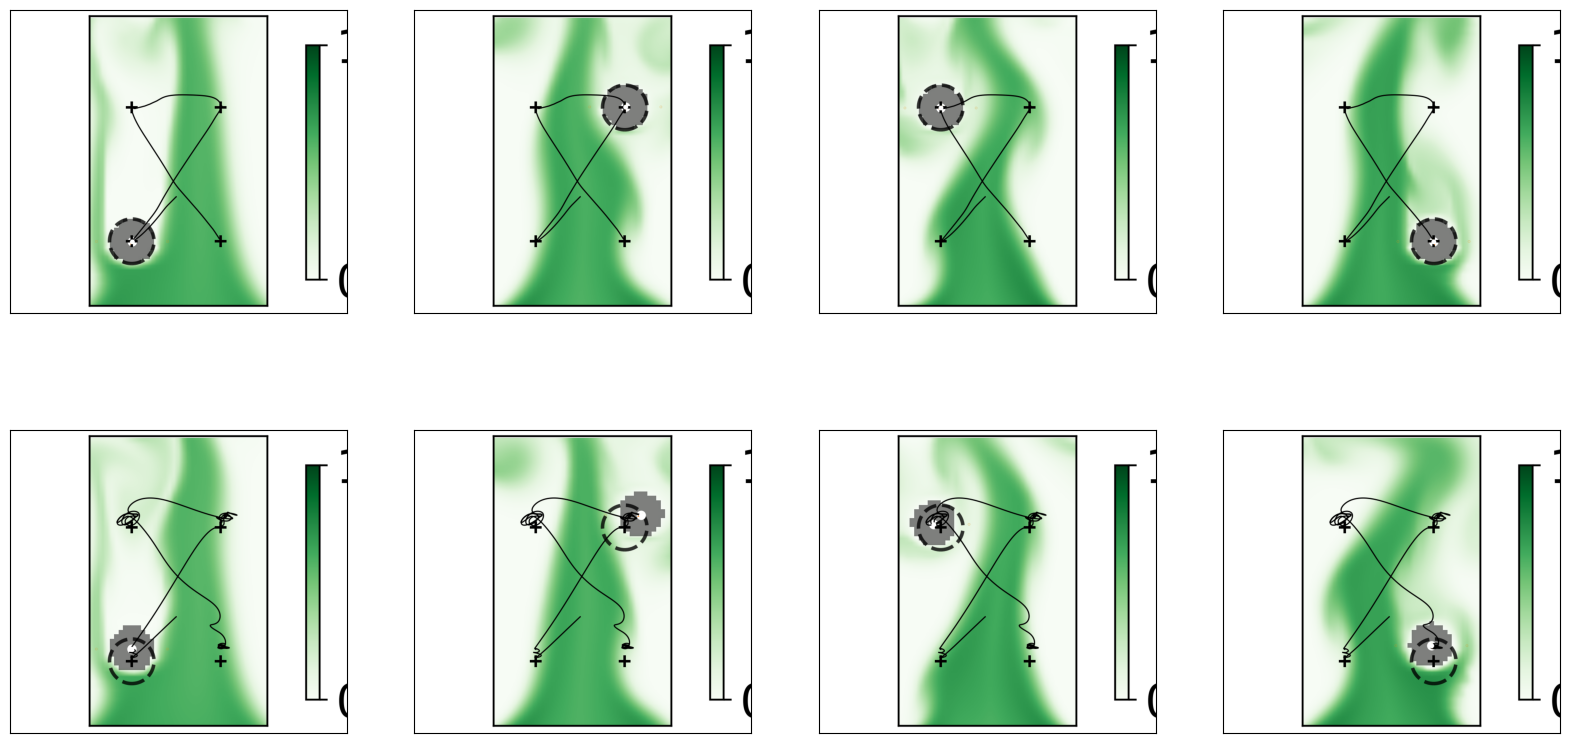

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axs = plt.subplots(2,4, figsize=(20,10))
snapshots = [1500, 3500, 5500, 7500]
for i, ax in enumerate(axs[0]):
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    img = mpimg.imread(f'/content/PhiFlow/storage/figs/diff_2dof_smoke_test2_case0000_{snapshots[i]:05d}.png')
    ax.imshow(img)

for i, ax in enumerate(axs[1]):
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    img = mpimg.imread(f'/content/PhiFlow/storage/trained_models/figs/supervised_2dof_smoke_test2_case0000_{snapshots[i]:05d}.png')
    ax.imshow(img)